In [1]:
"""
Copyright: This code is from "Python for finance, analyze big financial data", Yves Hilpisch
It is a highly recommended book for Python novices
"""

# Monte Carlo valuation of European call option
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from scipy import stats

np.random.seed(123)


# Parameter Values
S0 = 100.  # initial index level
K = 105.  # strike price
T = 1.0  # time-to-maturity
mu = 0.05  # risk-free short-term rate
sigma = 0.2  # volatility
n = 100000  # number of simulations

In [2]:
# Valuation Algorithm

# A random vector with normal distribution
z = np.random.standard_normal(n)
# Geometric Brownian Motion simulation of price at time T
ST = S0 * np.exp((mu - 0.5 * sigma ** 2) * T + sigma * z)

# index values at maturity
hT = np.maximum(ST - K, 0)  # Option values at maturity
C0 = np.exp(-mu * T) * np.sum(hT) / n  # Discount average option values to time 0

# Result Output
print("Simulation value of the European Call Option {:1.5f}".format(C0))

Simulation value of the European Call Option 8.04005


In [3]:
def bsm_call_value(S0, K, T, r, sigma):

    from math import log, sqrt, exp
    from scipy import stats

    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    d2 = (log(S0 / K) + (r - 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    bs_call = (S0 * stats.norm.cdf(x=d1, loc=0.0, scale=1.0) - K * exp(-r * T) * stats.norm.cdf(d2, 0.0, 1.0))
    print("B-S model for the European Call Option {:1.5f}".format(bs_call))
    return bs_call

bs_call = bsm_call_value(S0, K, 1, mu, sigma)

B-S model for the European Call Option 8.02135


In [109]:
# Implied volatility function
def bsm_call_imp_vol(S0, K, T, r, C0, sigma_est, it=100):
    for i in range(it):
        sigma_est -= ((bsm_call_value(S0, K, T, r, sigma_est) - C0) / bsm_vega(S0, K, T, r, sigma_est))
    return sigma_est

# Vega function
def bsm_vega(S0, K, T, r, sigma):
    from math import log, sqrt
    from scipy import stats
    
    S0 = float(S0)
    d1 = (log(S0 / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * sqrt(T))
    vega = S0 * stats.norm.pdf(d1, 0.0, 1.0) * sqrt(T)
    return vega

In [110]:
S0 = 17.6639  # asset price
r = 0.01  # interest rate
tol = 0.5  # tolerance level for moneyness

# Read VSTOXX futures and options data
futures_data = pd.read_hdf('source/vstoxx_data.h5', key='futures_data', mode='r')
options_data = pd.read_hdf('source/vstoxx_data.h5', key='options_data', mode='r')

# Altering timestamp to datetime
futures_data['DATE'] = pd.to_datetime(futures_data['DATE'], unit='ns')
futures_data['MATURITY'] = pd.to_datetime(futures_data['MATURITY'], unit='ns')

options_data['DATE'] = pd.to_datetime(options_data['DATE'], unit='ns')
options_data['MATURITY'] = pd.to_datetime(options_data['MATURITY'], unit='ns')

options_data[['DATE', 'MATURITY', 'TTM', 'STRIKE', 'PRICE']].head()
options_data['IMP_VOL'] = 0.0  # new column for implied volatilities

In [111]:
for num, option in options_data.iterrows():
    forward = futures_data[futures_data['MATURITY'] == option['MATURITY']]['PRICE'].values
    if forward.size > 0:
        forward = forward[0]
        if (forward * (1 - tol) < option['STRIKE'] < forward * (1 + tol)):
            imp_vol = bsm_call_imp_vol(
                S0=S0,
                K=option['STRIKE'],
                T=option['TTM'],
                r=r,
                C0=option['PRICE'],
                sigma_est=2.0,
                it=100)
            options_data.loc[num, 'IMP_VOL'] = imp_vol

plot_data = options_data[options_data['IMP_VOL'] > 0]

maturities = sorted(set(options_data['MATURITY']))
trade_date = options_data['DATE'].values[0]

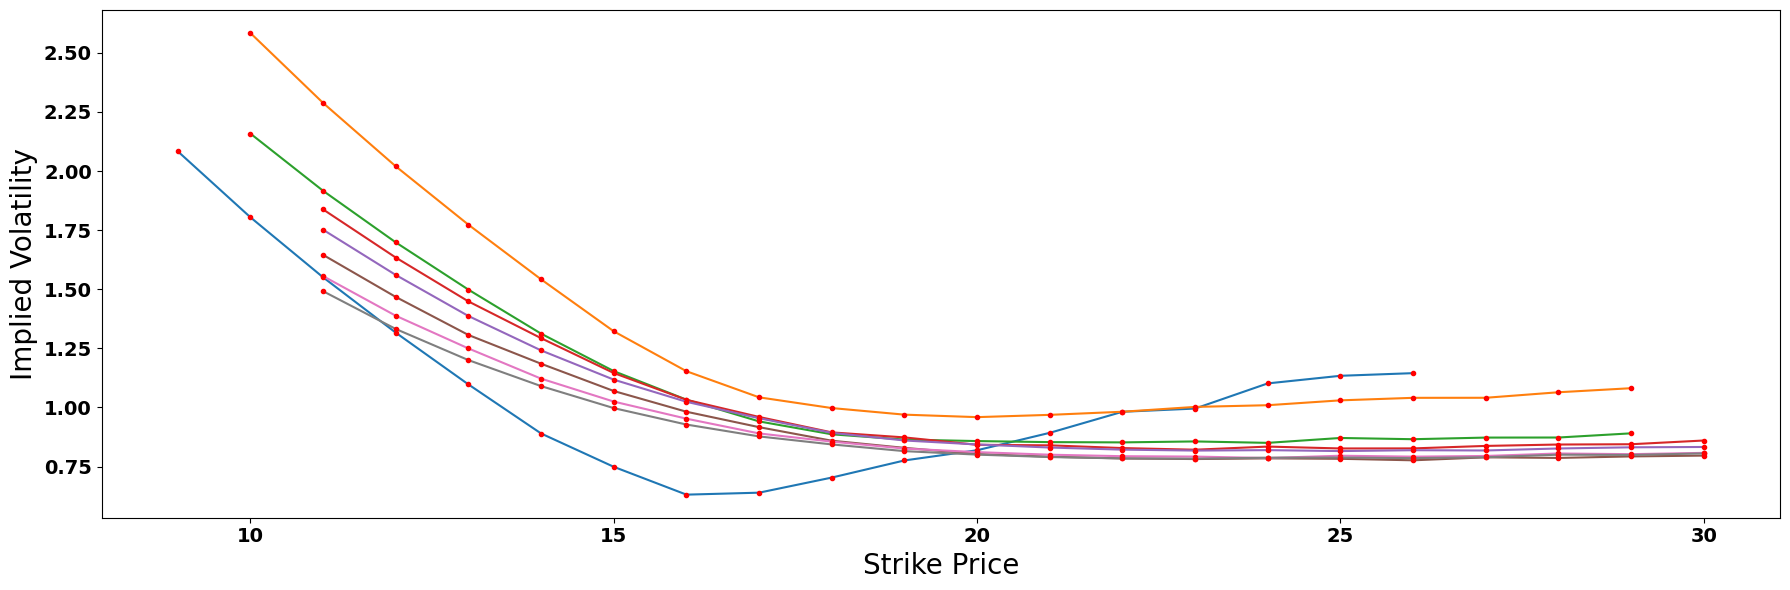

In [112]:
plt.figure(figsize=(18, 6))
for maturity in maturities:
    data = plot_data[plot_data['MATURITY'] == maturity]
    # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=f'{(maturity - trade_date).days}-days TTM', lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.', label='')
plt.xticks(fontsize=14, fontweight='heavy')
plt.yticks(fontsize=14, fontweight='heavy')
plt.xlabel('Strike Price', fontsize=20)
plt.ylabel('Implied Volatility', fontsize=20)
plt.tight_layout()
plt.savefig('IV_Strike.png', dpi=300, transparent=True)
plt.show()

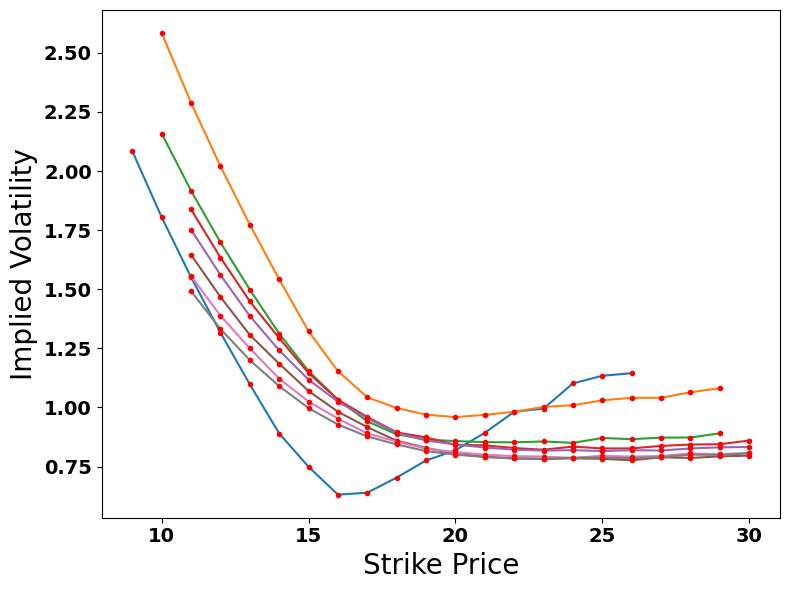

In [114]:
plt.figure(figsize=(8, 6))
for maturity in maturities:
    data = plot_data[plot_data['MATURITY'] == maturity]
    # select data for this maturity
    plt.plot(data['STRIKE'], data['IMP_VOL'], label=f'{(maturity - trade_date).days}-days TTM', lw=1.5)
    plt.plot(data['STRIKE'], data['IMP_VOL'], 'r.', label='')
plt.xticks(fontsize=14, fontweight='heavy')
plt.yticks(fontsize=14, fontweight='heavy')
plt.xlabel('Strike Price', fontsize=20)
plt.ylabel('Implied Volatility', fontsize=20)
plt.tight_layout()
plt.savefig('IV_Strike_Small_Ver.png', dpi=300, transparent=True)
plt.show()